Detected Tag: 5 at center: [504.77053046 162.43879709]
Detected Tag: 5 at center: [229.29193283 173.52321164]


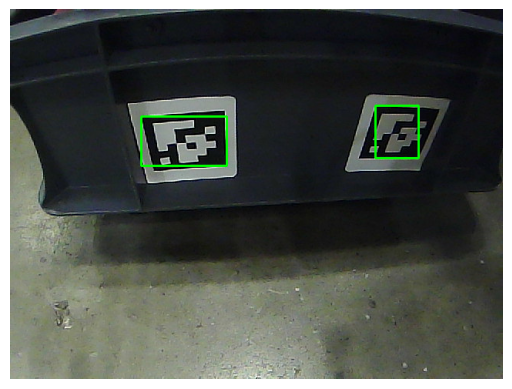

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import apriltag

show_bbox = True

# Load the image
path = "dataset/may15_run00_cam07/frame_380.png"
image = cv2.imread(path)

# Initialize the AprilTag detector
detector = apriltag.Detector()

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect AprilTags in the image
tags = detector.detect(gray_image)

# Draw bounding boxes around detected tags
for tag in tags:
    print('Detected Tag:', tag.tag_id, 'at center:', tag.center)

    if show_bbox:
        # Get the corners of the tag
        corners = tag.corners
        # Draw the bounding box
        pt1 = (int(corners[0][0]), int(corners[0][1]))
        pt2 = (int(corners[2][0]), int(corners[2][1]))
        cv2.rectangle(image, pt1, pt2, (0, 255, 0), 2)

# Convert the color space from BGR to RGB to display using matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


### Trying bounding box with canny edge detection

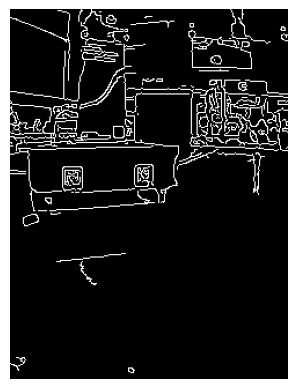

In [72]:
import cv2
import numpy as np

# Function to perform the operations
def find_bounding_boxes(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image")
        return
    
    # Rotate the image 90 degrees anticlockwise
    image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to smooth the image and reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours in the edged image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Loop over the contours
    for contour in contours:
        # Approximate the contour to a polygon
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        # The contour is considered a rectangle if it has 4 vertices
        if len(approx) == 4:
            # Compute the bounding box of the contour and draw it on the image
            (x, y, w, h) = cv2.boundingRect(approx)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Show the output image
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    plt.show()

# Call the function with the path to your image
find_bounding_boxes("dataset/frame_6500.png")


Finding bounding boxes for image dataset/frame_2520.png


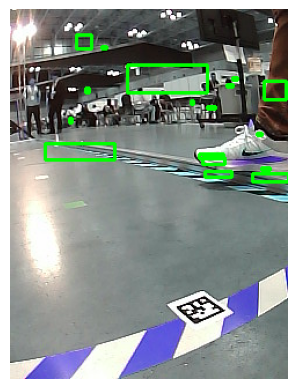

In [5]:
bins = 7040 // 20

import random

path = f"dataset/frame_{random.randint(0, bins) * 20}.png"
print(f"Finding bounding boxes for image {path}")
find_bounding_boxes(path)